In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

incubation_df = pd.read_csv("data-out/incubation_df.csv")

In [3]:
#get "mean incubation values" from single sentences and collect all info in a dataframe
incubation_table_docs = []
MEAN = ["mean", "average"]
for i in range(len(incubation_df)):
    for compound_sentence in re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', incubation_df["full_text"].values[i]):
        for simple_sentence in compound_sentence.split(", "):
            for m in MEAN:
                if m in simple_sentence and "incubation" in simple_sentence:
                    incubation_day = re.findall(r'( \d{1,2}(\.\d{1,2})? day[s]?)', simple_sentence)
                    if len(incubation_day) != 0:
                        num = incubation_day[0][0].split(" ")
                        incubation_table_docs.append([float(num[1]), 
                                                            incubation_day,
                                                            simple_sentence,
                                                            compound_sentence,
                                                            incubation_df["title"].values[i],
                                                            incubation_df["sha"].values[i],
                                                            incubation_df["publish_time"].values[i],
                                                            incubation_df["journal"].values[i],
                                                            incubation_df["url"].values[i]])

incubation_table = pd.DataFrame(incubation_table_docs, columns=["incubation_day",
                                                                "days",
                                                                "simple_sentence",
                                                                "compound_sentence",
                                                                "paper_title",
                                                                "sha",
                                                                "publish_time",
                                                                "journal",
                                                                "url"])
incubation_table.head()

,incubation_day,days,simple_sentence,compound_sentence,paper_title,sha,publish_time,journal,url
0,7.0,"[( 7 days, )]",we estimated that the length of isolation in t...,we estimated that the length of isolation in t...,Global versus focused isolation during the SAR...,08a40e31fde744729050ab037f80aa67c7d1053f,2020-04-01,NaN,https://doi.org/10.1101/2020.03.30.20047860
1,7.4,"[( 7.4 days, .4)]",the 483 confirmed patients were with average e...,"specifically, the 483 confirmed patients were ...",Epidemiological characteristics of 1212 COVID-...,091a8e9a61e19e88caeb039f0e3888d111b20439,2020-02-23,NaN,https://doi.org/10.1101/2020.02.21.20026112
2,7.4,"[( 7.4 days, .4)]",statistical analysis on 483 patients reveals t...,statistical analysis on 483 patients reveals t...,Epidemiological characteristics of 1212 COVID-...,091a8e9a61e19e88caeb039f0e3888d111b20439,2020-02-23,NaN,https://doi.org/10.1101/2020.02.21.20026112
3,5.0,"[( 5 day, ), ( 5 day, )]",comprising a mean about 5 day incubation perio...,"according to the recent report, there is a mea...",A simple model to assess Wuhan lock-down effec...,0bd443591b5e10934beef050b516afeca6b668fe,2020-03-03,NaN,https://doi.org/10.1101/2020.02.29.20029561
4,4.9,"[( 4.9 days, .9)]",we estimated that the mean incubation period w...,we estimated that the mean incubation period w...,High transmissibility of COVID-19 near symptom...,112e05c31018c816d0bd9ee64336eba79ee786ac,2020-03-19,NaN,https://doi.org/10.1101/2020.03.18.20034561


In [4]:
# skip duplicates by paper_id, compound sentence
incubation_table.drop_duplicates(subset="sha", inplace=True)
incubation_table.drop_duplicates(subset="compound_sentence", inplace=True)
incubation_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 137
Data columns (total 9 columns):
incubation_day       99 non-null float64
days                 99 non-null object
simple_sentence      99 non-null object
compound_sentence    99 non-null object
paper_title          91 non-null object
sha                  99 non-null object
publish_time         99 non-null object
journal              39 non-null object
url                  99 non-null object
dtypes: float64(1), object(8)
memory usage: 7.7+ KB


In [5]:
incubation_table.to_csv("data-out/incubation_table_mean.csv", index=False, header=True)

In [7]:
#go through the csv file, then pick sentences with incorrect resutts
sentences_to_delete = ["the average incubation period is between 2 and 21 days",
                        "we found that the mean incubation period of covid-19 was 8.08 (5.06) days and ranged from 1 to 20 days.",
                        "we estimated that the length of isolation in the high risk population will decrease from two weeks to an average of 7 days which is within the range of the average incubation period (6) (7) (8) .",
                        "we conducted sensitivity analyses to examine how varying the mean incubation period between 5.5 and 9.5 days affects our estimates of the true asymptomatic proportion.",
                        "we assumed the mean incubation period and mean infectious period to be 6·4 days 16 and 3 days or 7 days"]

update_dict = {"our results show the incubation mean and median of covid-19 are 5.84 and 5.0 days respectively and there is a statistical significance with the role of gender.": 5.84,
                    "the median incubation period for covid-19 is approximately 5.1 days (mean 5.5 days)\n\n• in 97.5% of infected persons": 5.5,
                    "the incubation period for wuhan travelers estimated from 2.1 to 11.1 days (the mean incubation period was estimated to be 6.4 days)": 6.4,
                    "studies have suggested an incubation period of 16 days with a mean of 5-6 days [12": 6.0,
                    "the average incubation period has changed from 7 days determined in january to 3 days estimated recently": 3.0,
                    "they also estimated mean incubation and contagious periods of 5 and 11 days": 5.0,
                    "compared to the mean incubation period of 6.4 days of sars [3]": 5.2}
sentences_to_update = list(update_dict.keys())

no_of_error = len(sentences_to_delete) + len(sentences_to_update)
error_percentage = no_of_error/len(incubation_table["incubation_day"].values)*100
print("error %: ", error_percentage)

error %:  12.121212121212121


In [8]:
#drop non-related results
incubation_table = incubation_table[~incubation_table["simple_sentence"].isin(sentences_to_delete)]
incubation_table.shape

(94, 9)

In [10]:
#update correct results
to_update = incubation_table.copy()[incubation_table["simple_sentence"].isin(sentences_to_update)]
to_update["incubation_day"] = to_update["simple_sentence"].map(update_dict)
incubation_table = incubation_table[~incubation_table["simple_sentence"].isin(sentences_to_update)]
incubation_table = pd.concat([incubation_table, to_update])
incubation_table.shape

(94, 9)

In [12]:
#get incubation mean values
incubation_means = incubation_table["incubation_day"].values
print(incubation_table.groupby("incubation_day")["compound_sentence"].count().sort_values(ascending=False))

incubation_day
5.20     29
5.00     17
6.40     12
7.00      7
3.00      6
6.00      4
5.50      2
4.60      2
4.90      2
5.10      2
10.00     2
5.84      1
8.42      1
6.10      1
7.10      1
5.01      1
7.40      1
7.44      1
7.50      1
5.90      1
Name: compound_sentence, dtype: int64


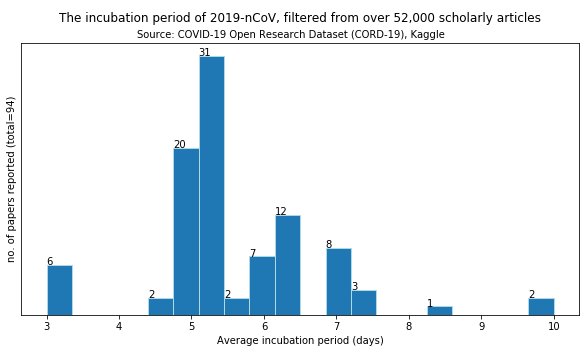

In [13]:
#plot results
fig, ax = plt.subplots(figsize=[10,5])
bins = int(max(incubation_means))*2
arr = plt.hist(incubation_means, ec="lightblue", bins=bins)
for i in range(bins):
    if arr[0][i] != 0:
        plt.text(arr[1][i],arr[0][i],str(int(arr[0][i])))
ax.set_yticklabels([])
ax.set_yticks([])
plt.ylabel(f"no. of papers reported (total={len(incubation_means)})")
plt.xlabel("Average incubation period (days)")
plt.title("The incubation period of 2019-nCoV, filtered from over 52,000 scholarly articles\n")
plt.suptitle("\n\nSource: COVID-19 Open Research Dataset (CORD-19), Kaggle\n\n", fontsize=10)
plt.show()